In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Activation
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(7777)

In [3]:
trend_train = np.arange(11,111, dtype='float64') + np.random.normal(scale=2, size=100)
trend_test_outofrange = np.arange(111,131, dtype='float64') + np.random.normal(scale=2, size=20)
trend_test_inrange = np.arange(31,51, dtype='float64') + np.random.normal(scale=2, size=20)

train = trend_train
test = trend_test_outofrange

In [4]:
lstm_stateful = False

lstm_num_timesteps = 4 # for diffed series
lstm_num_predictions = lstm_num_timesteps
effective_timesteps = lstm_num_timesteps+1
lstm_num_features = 1

num_neurons = 4
batchsize = 1
num_epochs = 500

In [5]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return(diff)

def inverse_difference(history, yhat, interval=1):
    # history[-len(series)] is first item, history[-len(series) - 1] is second, etc. 
    return yhat + history[-interval]

In [6]:
train_diff = difference(train, 1)
test_diff = difference(test, 1)
test_diff

[0.27338302596317021,
 1.7310265497711441,
 1.7451128164638021,
 0.29727845971444822,
 -0.061718680499211587,
 2.0725813598952101,
 -3.0916986883747199,
 3.3959042561117627,
 5.4305546542064178,
 0.16910568625694111,
 0.90280661853361721,
 -0.65152964591959517,
 1.5494066806911633,
 -0.63092790701740853,
 2.8014413479762936,
 1.8094951282746763,
 -0.45663481451620669,
 2.7467181214053369,
 -2.3186887828005354]

In [7]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


values = [x for x in range(10)]
data = series_to_supervised(values,3,3)
print(data)

   var1(t-3)  var1(t-2)  var1(t-1)  var1(t)  var1(t+1)  var1(t+2)
3        0.0        1.0        2.0        3        4.0        5.0
4        1.0        2.0        3.0        4        5.0        6.0
5        2.0        3.0        4.0        5        6.0        7.0
6        3.0        4.0        5.0        6        7.0        8.0
7        4.0        5.0        6.0        7        8.0        9.0


In [8]:
train_diff_df = series_to_supervised(train_diff,lstm_num_timesteps, lstm_num_predictions)
test_diff_df = series_to_supervised(test_diff,lstm_num_timesteps, lstm_num_predictions)
test_diff_df

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3)
4,0.273383,1.731027,1.745113,0.297278,-0.061719,2.072581,-3.091699,3.395904
5,1.731027,1.745113,0.297278,-0.061719,2.072581,-3.091699,3.395904,5.430555
6,1.745113,0.297278,-0.061719,2.072581,-3.091699,3.395904,5.430555,0.169106
7,0.297278,-0.061719,2.072581,-3.091699,3.395904,5.430555,0.169106,0.902807
8,-0.061719,2.072581,-3.091699,3.395904,5.430555,0.169106,0.902807,-0.651530
9,2.072581,-3.091699,3.395904,5.430555,0.169106,0.902807,-0.651530,1.549407
10,-3.091699,3.395904,5.430555,0.169106,0.902807,-0.651530,1.549407,-0.630928
11,3.395904,5.430555,0.169106,0.902807,-0.651530,1.549407,-0.630928,2.801441
12,5.430555,0.169106,0.902807,-0.651530,1.549407,-0.630928,2.801441,1.809495
13,0.169106,0.902807,-0.651530,1.549407,-0.630928,2.801441,1.809495,-0.456635


In [9]:
train_diff_matrix = train_diff_df.values
test_diff_matrix = test_diff_df.values

In [10]:
test_diff_matrix

array([[ 0.27338303,  1.73102655,  1.74511282,  0.29727846, -0.06171868,
         2.07258136, -3.09169869,  3.39590426],
       [ 1.73102655,  1.74511282,  0.29727846, -0.06171868,  2.07258136,
        -3.09169869,  3.39590426,  5.43055465],
       [ 1.74511282,  0.29727846, -0.06171868,  2.07258136, -3.09169869,
         3.39590426,  5.43055465,  0.16910569],
       [ 0.29727846, -0.06171868,  2.07258136, -3.09169869,  3.39590426,
         5.43055465,  0.16910569,  0.90280662],
       [-0.06171868,  2.07258136, -3.09169869,  3.39590426,  5.43055465,
         0.16910569,  0.90280662, -0.65152965],
       [ 2.07258136, -3.09169869,  3.39590426,  5.43055465,  0.16910569,
         0.90280662, -0.65152965,  1.54940668],
       [-3.09169869,  3.39590426,  5.43055465,  0.16910569,  0.90280662,
        -0.65152965,  1.54940668, -0.63092791],
       [ 3.39590426,  5.43055465,  0.16910569,  0.90280662, -0.65152965,
         1.54940668, -0.63092791,  2.80144135],
       [ 5.43055465,  0.16910569

In [11]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [y for y in yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -lstm_num_timesteps:]


In [12]:
scaler, train_scaled, test_scaled = scale(train_diff_matrix, test_diff_matrix)
test_scaled

array([[ 0.15835973,  0.34382199,  0.34561424,  0.16140005,  0.11572329,
         0.38727948, -0.26979411,  0.55565155],
       [ 0.34382199,  0.34561424,  0.16140005,  0.11572329,  0.38727948,
        -0.26979411,  0.55565155,  0.81452888],
       [ 0.34561424,  0.16140005,  0.11572329,  0.38727948, -0.26979411,
         0.55565155,  0.81452888,  0.14509207],
       [ 0.16140005,  0.11572329,  0.38727948, -0.26979411,  0.55565155,
         0.81452888,  0.14509207,  0.238444  ],
       [ 0.11572329,  0.38727948, -0.26979411,  0.55565155,  0.81452888,
         0.14509207,  0.238444  ,  0.04067911],
       [ 0.38727948, -0.26979411,  0.55565155,  0.81452888,  0.14509207,
         0.238444  ,  0.04067911,  0.32071371],
       [-0.26979411,  0.55565155,  0.81452888,  0.14509207,  0.238444  ,
         0.04067911,  0.32071371,  0.04330035],
       [ 0.55565155,  0.81452888,  0.14509207,  0.238444  ,  0.04067911,
         0.32071371,  0.04330035,  0.48001547],
       [ 0.81452888,  0.14509207

In [13]:
def fit_lstm_stateful(train, batchsize, num_epochs, num_neurons):    
    X, y = train[:, 0:lstm_num_timesteps], train[:, lstm_num_timesteps:]
    # reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], lstm_num_timesteps, lstm_num_features))
    y = np.reshape(y, (y.shape[0], lstm_num_predictions, lstm_num_features))
    model = Sequential()
    model.add(LSTM(num_neurons, batch_input_shape=(batchsize, X.shape[1], X.shape[2]),
                   stateful=True, return_sequences = True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Activation("linear"))  
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    for i in range(num_epochs):
        model.fit(X, y, epochs=1, batch_size=batchsize, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [14]:
def fit_lstm_stateless(train, batchsize, num_epochs, num_neurons):
    X, y = train[:, 0:lstm_num_timesteps], train[:, lstm_num_timesteps:]
    # reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], lstm_num_timesteps, lstm_num_features))
    y = np.reshape(y, (y.shape[0], lstm_num_predictions, lstm_num_features))
    model = Sequential()
    model.add(LSTM(num_neurons, batch_input_shape=(batchsize, X.shape[1], X.shape[2]), return_sequences = True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Activation("linear"))  
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    model.fit(X, y, epochs=num_epochs, batch_size=batchsize, verbose=1, shuffle=True)
    return model

In [15]:
def forecast_lstm(model, batch_size, X):
    if lstm_stateful:
         model.reset_states()
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,:,0]

In [16]:
train_diff = difference(train, 1)
test_diff = difference(test, 1)
train_matrix = series_to_supervised(train_diff, lstm_num_timesteps, lstm_num_predictions).values
test_matrix = series_to_supervised(test_diff, lstm_num_timesteps, lstm_num_predictions).values
scaler, train_scaled, test_scaled = scale(train_matrix, test_matrix)

if lstm_stateful:
    lstm_model = fit_lstm_stateful(train_scaled, batchsize, num_epochs, num_neurons)
else:
    lstm_model = fit_lstm_stateless(train_scaled, batchsize, num_epochs, num_neurons)
        
train_predictions = list()
for i in range(len(train_scaled)):
    X, y = train_scaled[i, 0:lstm_num_timesteps], train_scaled[i, lstm_num_timesteps:]
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(train, yhat, len(train_scaled)+1-i)
    train_predictions.append(yhat)
            
test_predictions = list()
for i in range(len(test_scaled)):
    X, y = train_scaled[i, 0:lstm_num_timesteps], train_scaled[i, lstm_num_timesteps:]
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(test, yhat, len(test_scaled)+1-i)
    test_predictions.append(yhat)
         

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4, 4)                 96        
_________________________________________________________________
time_distributed_1 (TimeDist (1, 4, 1)                 5         
_________________________________________________________________
activation_1 (Activation)    (1, 4, 1)                 0         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
92/92 [==============================] - 0s - loss: 0.1833     
Epoch 2/500
92/92 [==============================] - 0s - loss: 0.1542     
Epoch 3/500
92/92 [==============================] - 0s - loss: 0.1518     
Epoch 4/500
92/92 [==============================] - 0s - loss: 0.1514     
Epoch 5/500
92/92 [==============================] - 0s - loss: 0.1511     
Epoch 6/500
92/92 [=========

92/92 [==============================] - 0s - loss: 0.1383     
Epoch 99/500
92/92 [==============================] - 0s - loss: 0.1380     
Epoch 100/500
92/92 [==============================] - 0s - loss: 0.1380     
Epoch 101/500
92/92 [==============================] - 0s - loss: 0.1379     
Epoch 102/500
92/92 [==============================] - 0s - loss: 0.1378     
Epoch 103/500
92/92 [==============================] - 0s - loss: 0.1375     
Epoch 104/500
92/92 [==============================] - 0s - loss: 0.1374     
Epoch 105/500
92/92 [==============================] - 0s - loss: 0.1371     
Epoch 106/500
92/92 [==============================] - 0s - loss: 0.1370     
Epoch 107/500
92/92 [==============================] - 0s - loss: 0.1371     
Epoch 108/500
92/92 [==============================] - 0s - loss: 0.1369     
Epoch 109/500
92/92 [==============================] - 0s - loss: 0.1366     
Epoch 110/500
92/92 [==============================] - 0s - loss: 0.1364     
E

92/92 [==============================] - 0s - loss: 0.1317     
Epoch 204/500
92/92 [==============================] - 0s - loss: 0.1317     
Epoch 205/500
92/92 [==============================] - 0s - loss: 0.1316     
Epoch 206/500
92/92 [==============================] - 0s - loss: 0.1317     
Epoch 207/500
92/92 [==============================] - 0s - loss: 0.1317     
Epoch 208/500
92/92 [==============================] - 0s - loss: 0.1317     
Epoch 209/500
92/92 [==============================] - 0s - loss: 0.1316     
Epoch 210/500
92/92 [==============================] - 0s - loss: 0.1314     
Epoch 211/500
92/92 [==============================] - 0s - loss: 0.1314     
Epoch 212/500
92/92 [==============================] - 0s - loss: 0.1316     
Epoch 213/500
92/92 [==============================] - 0s - loss: 0.1317     
Epoch 214/500
92/92 [==============================] - 0s - loss: 0.1314     
Epoch 215/500
92/92 [==============================] - 0s - loss: 0.1313     


92/92 [==============================] - 0s - loss: 0.1288     
Epoch 309/500
92/92 [==============================] - 0s - loss: 0.1286     
Epoch 310/500
92/92 [==============================] - 0s - loss: 0.1287     
Epoch 311/500
92/92 [==============================] - 0s - loss: 0.1288     
Epoch 312/500
92/92 [==============================] - 0s - loss: 0.1287     
Epoch 313/500
92/92 [==============================] - 0s - loss: 0.1285     
Epoch 314/500
92/92 [==============================] - 0s - loss: 0.1286     
Epoch 315/500
92/92 [==============================] - 0s - loss: 0.1286     
Epoch 316/500
92/92 [==============================] - 0s - loss: 0.1284     
Epoch 317/500
92/92 [==============================] - 0s - loss: 0.1285     
Epoch 318/500
92/92 [==============================] - 0s - loss: 0.1284     
Epoch 319/500
92/92 [==============================] - 0s - loss: 0.1283     
Epoch 320/500
92/92 [==============================] - 0s - loss: 0.1286     


92/92 [==============================] - 0s - loss: 0.1267     
Epoch 414/500
92/92 [==============================] - 0s - loss: 0.1265     
Epoch 415/500
92/92 [==============================] - 0s - loss: 0.1267     
Epoch 416/500
92/92 [==============================] - 0s - loss: 0.1264     
Epoch 417/500
92/92 [==============================] - 0s - loss: 0.1264     
Epoch 418/500
92/92 [==============================] - 0s - loss: 0.1265     
Epoch 419/500
92/92 [==============================] - 0s - loss: 0.1263     
Epoch 420/500
92/92 [==============================] - 0s - loss: 0.1264     
Epoch 421/500
92/92 [==============================] - 0s - loss: 0.1265     
Epoch 422/500
92/92 [==============================] - 0s - loss: 0.1263     
Epoch 423/500
92/92 [==============================] - 0s - loss: 0.1263     
Epoch 424/500
92/92 [==============================] - 0s - loss: 0.1262     
Epoch 425/500
92/92 [==============================] - 0s - loss: 0.1264     


In [17]:
test_predictions[:10]

[array([ 114.55276816,  115.67039847,  113.51375201,  114.82428757]),
 array([ 117.96469106,  117.41003363,  119.55561744,  118.67197347]),
 array([ 123.29748414,  123.91913655,  123.32268702,  124.1357005 ]),
 array([ 124.29695169,  122.99178074,  124.64701184,  122.06088905]),
 array([ 125.12049777,  122.60947415,  124.40177033,  127.02602864]),
 array([ 124.09604297,  123.77633317,  124.57936791,  124.54257149]),
 array([ 125.48332493,  126.34720981,  124.96748768,  125.97355549]),
 array([ 124.63579619,  124.79778025,  125.7266907 ,  124.23497449]),
 array([ 127.50200298,  128.56589068,  126.49602559,  127.91528113]),
 array([ 129.33847646,  128.77850994,  130.40324253,  131.72731751])]

In [18]:
train_predictions[:10]

[array([ 19.66373202,  20.78136233,  18.62471587,  19.93525143]),
 array([ 19.7901582 ,  19.23550077,  21.38108458,  20.4974406 ]),
 array([ 21.26706776,  21.88872017,  21.29227064,  22.10528411]),
 array([ 21.41894242,  20.11377147,  21.76900257,  19.18287978]),
 array([ 21.96777524,  19.45675162,  21.2490478 ,  23.87330611]),
 array([ 25.26527782,  24.94556803,  25.74860276,  25.71180635]),
 array([ 23.88206567,  24.74595056,  23.36622842,  24.37229623]),
 array([ 23.14237311,  23.30435718,  24.23326762,  22.74155141]),
 array([ 23.03341283,  24.09730053,  22.02743543,  23.44669098]),
 array([ 27.45994206,  26.89997554,  28.52470813,  29.8487831 ])]

In [19]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    padding = [np.nan for i in range(effective_timesteps)]
    plt.plot(padding + predicted_data, label='Prediction')
    plt.legend()
    plt.show()

In [20]:
def plot_results_multiple(predicted_data, true_data, prediction_window):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = np.array([np.nan for p in range((i+1) * 4)])
        plt.plot(np.append(padding,data))
    #plt.savefig(fig_name)
    plt.show()

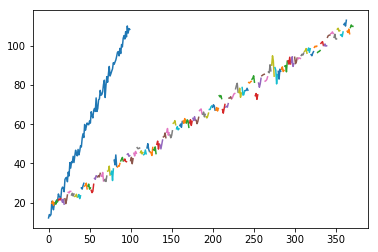

In [21]:
plot_results_multiple(train_predictions, train, lstm_num_predictions)

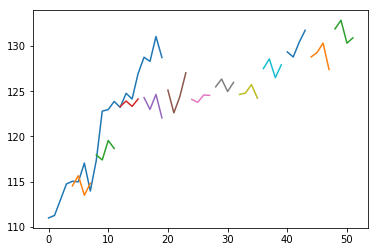

In [22]:
plot_results_multiple(test_predictions, test, lstm_num_predictions)